# Let's take a stab at some linear regression

You can find all the code and datasets on my [project github](https://github.com/stevendevan/KaggleHousePrices).

My code is more modularized there, but I will reproduce the functions in this notebook so you can see the source code.

## 1. Initial look and cleaning
First of all we'll import some modules for plotting and data manipulation, and call our bread-and-butter head() function.

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9, 6]

infolder = 'data/input/'
outfolder = 'data/output/'

df_train_raw = pd.read_csv(infolder + 'train.csv')
df_test_raw = pd.read_csv(infolder +  'test.csv')

print('Training data: {s[0]} rows, {s[1]} columns'.format(s=df_train_raw.shape))
print('Testing data: {s[0]} rows, {s[1]} columns'.format(s=df_test_raw.shape))
df_train_raw.head()

Training data: 1460 rows, 81 columns
Testing data: 1459 rows, 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


As it's always useful to learn more about the data itself, how it was collected, etc., let's check out the [documentation.](http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt)
Toward the bottom, under the 'Special Notes' section, the author recommends removing any observations for which GrLivArea > 4000, as he says those can safely be considered true anomalies. Let's do that now.

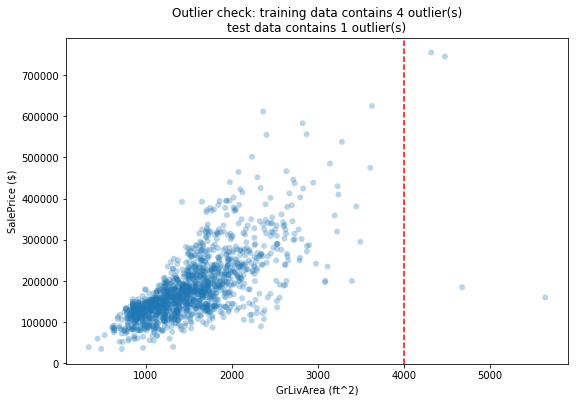

In [10]:
plt.scatter(df_train_raw['GrLivArea'], df_train_raw['SalePrice'],
            alpha=0.3, edgecolor='none');
plt.axvline(4000, ls='--', c='r');
plt.title('Outlier check: training data contains {} outlier(s)\n'
          'test data contains {} outlier(s)'
          .format(sum(df_train_raw['GrLivArea'] > 4000),
                  sum(df_test_raw['GrLivArea'] > 4000)));
plt.xlabel('GrLivArea (ft^2)');
plt.ylabel('SalePrice ($)');

# The big moment. Don't forget to reset the index.
df_train_raw.drop(df_train_raw[(df_train_raw['GrLivArea'] > 4000)].index, 
                  inplace=True)
df_train_raw.reset_index(inplace=True, drop=True)

Now let's spearate out the dependent variable and concatenate both the train and test data for null investigation and convenient cleaning.

In [11]:
y = df_train_raw['SalePrice'] # Dependent variable
df_train_raw.drop(['SalePrice'], axis=1, inplace=True)
df_all_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

### Explore NaNs and fill
Here I will reproduce the primary data conditioning function that I use. I will then elaborate on some of the actions in the function and include example plots. It is critical that you take a look at the [data_description file]( provided with the data on the Kaggle website), as it clarifies most of what we'll have to do for the NaN-filling work.

In [12]:
def condition_housing_data(df):
    """General data-conditioning function to prepare the housing DataFrame for
    analysis. Mostly NaN filling
    """

    fillnone = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
                'MasVnrType']

    fillzero = ['GarageArea', 'TotalBsmtSF', 'LotFrontage', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

    fillmode = ['Electrical', 'KitchenQual', 'SaleType', 'Exterior1st',
                'Exterior2nd', 'Functional', 'MasVnrType', 'MSZoning']

    # has some NaNs. Value is highly correlated with YearBuilt
    df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)

    # There seems to be an erroneous value for GarageYrBlt of 2207
    # Based on the YearBuilt being 2006, I assume it should be 2007
    df.loc[df.GarageYrBlt == 2207.0, 'GarageYrBlt'] = 2007.0

    # Convert column to strings. It's categorical data stored as int64
    df['MSSubClass'] = df['MSSubClass'].astype(str)

    # Really only one value present
    df.drop(['Utilities'], axis=1, inplace=True)

    # Apparently this can't be done without looping.
    for colname in fillnone:
        df[colname].fillna('none', inplace=True)

    for colname in fillzero:
        df[colname].fillna(0, inplace=True)

    for colname in fillmode:
        df[colname].fillna(df[colname].mode()[0], inplace=True)

    return df


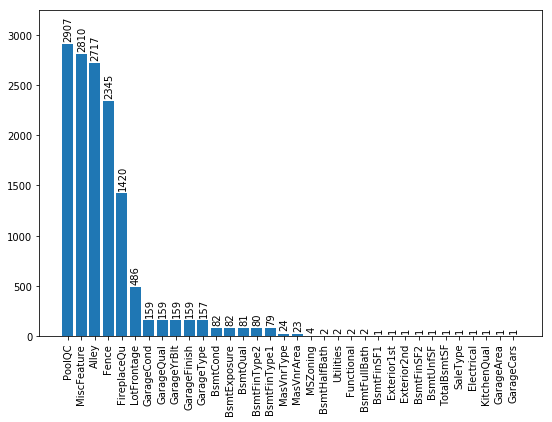

In [13]:
nullcols = df_all_raw.isnull().sum(axis=0).sort_values(ascending=False)
nullcols = nullcols[nullcols > 0]

plt.bar(nullcols.index, nullcols);
plt.ylim(0, 3250)
for xpos, ypos in enumerate(nullcols.values):
    plt.text(xpos + .06, ypos + 30, str(ypos), 
             ha='center', va='bottom', rotation=90, color='black');
plt.xticks(range(len(nullcols)), nullcols.index, rotation=90);

We can see from the plot above that the vast majority of NaNs fall into the fillnone category, which is very convenient. I wouldn't even consider NaNs in those features as 'missing', but rather just requiring a conversion to string.

As noted in the function comments, 'MSSubClass' is a categorical variable stored as int64. A simple conversion to string fixes this.

The training set effectively only contains one value for 'Utilities', making it useless for analysis.

In [14]:
print(df_train_raw['Utilities'].groupby(df_train_raw['Utilities']).count() \
                               .sort_values(ascending=False))

Utilities
AllPub    1455
NoSeWa       1
Name: Utilities, dtype: int64


There appears to be a garage from the future. We will assume it was meant to be 200X, not 220X. 


Also, we can see from the plot below that in most cases, the year the house was built and the year the garage was built are the same, making 'YearBuilt' a suitable NaN filler for 'GarageYrBlt'

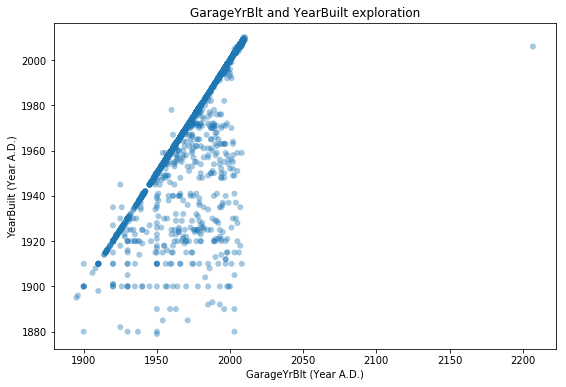

In [15]:
plt.scatter(df_all_raw['GarageYrBlt'], df_all_raw['YearBuilt'],
            alpha=0.4, edgecolor='none');
plt.title('GarageYrBlt and YearBuilt exploration');
plt.xlabel('GarageYrBlt (Year A.D.)');
plt.ylabel('YearBuilt (Year A.D.)');

NaN filling the rest of the data is pretty straightforward. We can split the remaining features into 3 categories that I call **fillnone**, **fillzero**, and **fillmode**. 

Going through the description of each variable in the data_description.txt file, some of the features indicate that NA just means that a property doesn't have that feature. We can treat this as a category in itself and fill those NaNs with the string 'none'.

For some NaNs in numerical features, this usually means that there is zero of that feature, e.g. zero square feet or zero bathrooms. In these cases, we will fill NaNs with zero.

Finally, there are some categorical features for which a NaN has no obvious meaning. Many of these features are dominated by a single value, so we will fill those NaNs with the mode value.

TODO: A potential improvement could be a more sophisitcated NaN filler for the fillmode features. This would probably be a predictive modeling task in itself.

### So let's go ahead and condition the data

In [16]:
df_all = condition_housing_data(df_all_raw)
print('There are now {} null values in the data.'
      .format(df_all.isnull().sum().sum()))

There are now 0 null values in the data.


## 2. EDA